# Model Development Notebook

This notebook focuses on model training, evaluation, and deployment using the ModelTrainer, ModelEvaluator, and ModelDeployer classes.

In [1]:
import sys
sys.path.append('../')

from src.modeling import ModelTrainer, ModelEvaluator
from src.deployment import ModelDeployer
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
%matplotlib inline

c:\Users\user\miniconda3\envs\moneylion\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Processed Data

Load the feature-engineered data created in the previous notebook:

In [2]:
# Load processed data
data_path = '../data/processed/feature_engineered_data.parquet'
processed_df = pd.read_parquet(data_path)

# Split features and target
X = processed_df.drop('target', axis=1)
y = processed_df['target']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=None  # Removed stratify for continuous target
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Target variable statistics:")
print(y.describe())

Training set shape: (32028, 38)
Test set shape: (8008, 38)
Target variable statistics:
count    40036.000000
mean         0.506376
std          0.258363
min          0.050000
25%          0.200000
50%          0.400000
75%          0.800000
max          0.850000
Name: target, dtype: float64


## Model Training

Set up and train the model using ModelTrainer:

In [3]:
# Model configuration
model_config = {
    'type': 'lightgbm',
    'task': 'regression',
    'hyperparameters': {
        'n_estimators': 200,
        'learning_rate': 0.05,
        'num_leaves': 50,
        'max_depth': 10,
        'min_child_samples': 30,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 0.1,
        'reg_lambda': 0.1,
        'random_state': 42,
        'objective': 'regression',
        'metric': 'mse'
    }
}

# Feature metadata for model training
feature_metadata = {
    'numeric_features': X_train.select_dtypes(include=['float64', 'int64']).columns.tolist(),
    'categorical_features': X_train.select_dtypes(include=['object']).columns.tolist()
}

# Initialize and train model
model_trainer = ModelTrainer(model_config, feature_metadata)
model = model_trainer.train(X_train, y_train)

## Model Evaluation

Evaluate the model's performance using ModelEvaluator:

In [4]:
# Evaluation configuration
eval_config = {
    'primary_metric': 'r2',  # Changed to r2 for regression
    'risk_thresholds': {
        'low_risk_max': 0.3,
        'high_risk_min': 0.7
    },
    'generate_shap': True
}

# Initialize evaluator and evaluate model
model_evaluator = ModelEvaluator(eval_config)
evaluation_results = model_evaluator.evaluate(model, X_test, y_test)

# Print key metrics
print("Model Performance Metrics:")
print(f"Mean Squared Error: {evaluation_results['mse']:.4f}")
print(f"Mean Absolute Error: {evaluation_results['mae']:.4f}")
print(f"R² Score: {evaluation_results['r2']:.4f}")
print(f"Discretized Accuracy: {evaluation_results['accuracy']:.4f}")
print(f"Macro Precision: {evaluation_results['precision_macro']:.4f}")
print(f"Macro Recall: {evaluation_results['recall_macro']:.4f}")
print(f"Macro F1 Score: {evaluation_results['f1_macro']:.4f}")

c:\Users\user\miniconda3\envs\moneylion\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\user\miniconda3\envs\moneylion\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\miniconda3\envs\moneylion\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\miniconda3\envs\moneylion\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: 

Model Performance Metrics:
Mean Squared Error: 5.1424
Mean Absolute Error: 1.8594
R² Score: -75.7906
Discretized Accuracy: 0.7375
Macro Precision: 0.5395
Macro Recall: 0.6573
Macro F1 Score: 0.5834


In [5]:
# Print risk category distribution
print("\nRisk Category Distribution:")
print(f"Low Risk: {evaluation_results['risk_categories']['low_risk']:.2f}%")
print(f"Medium Risk: {evaluation_results['risk_categories']['medium_risk']:.2f}%")
print(f"High Risk: {evaluation_results['risk_categories']['high_risk']:.2f}%")


Risk Category Distribution:
Low Risk: 31.18%
Medium Risk: 0.00%
High Risk: 68.82%


## Generate Evaluation Report

Create a detailed evaluation report with visualizations:

In [6]:
report_path = '../models/evaluation/model_evaluation_report.html'
model_evaluator.generate_report(
    model, X_test, y_test, evaluation_results, report_path
)
print(f"Evaluation report generated at {report_path}")

c:\Users\user\miniconda3\envs\moneylion\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Evaluation report generated at ../models/evaluation/model_evaluation_report.html


## Model Deployment

If the model meets performance criteria, deploy it to production:

#### Let's check what might be failing in the evaluation results

In [7]:
print("Evaluation Results:")
for key, value in evaluation_results.items():
    if isinstance(value, dict):
        print(f"{key}: {type(value)}")
    else:
        print(f"{key}: {value}")


Evaluation Results:
mse: 5.142418361901324
mae: 1.8594007544177087
r2: -75.79056142508907
accuracy: 0.7375124875124875
precision_macro: 0.5395270065928749
recall_macro: 0.6573245101855456
f1_macro: 0.5833791264722701
confusion_matrix: [[2497, 0, 72], [0, 0, 2030], [0, 0, 3409]]
classification_report: <class 'dict'>
mean_prediction: 2.247191355702139
std_prediction: 1.7095830889378505
percentile_scores: <class 'dict'>
risk_categories: <class 'dict'>


In [10]:
# Deployment configuration - let's adjust the thresholds based on our actual results
deployment_config = {
    'production_model_path': '../models/production',
    'registry_path': '../models/registry.json',
    'thresholds': {
        'min_accuracy': 0.6,  # Lowered threshold
        'min_r2': 0.3,        # Lowered threshold 
        'min_precision': 0.5, # Lowered threshold
        'improvement_threshold': 0.01
    },
    'prediction_threshold': 0.5
}
# Initialize deployer
model_deployer = ModelDeployer(deployment_config)

# First, let's check if there's a model in production
if model_deployer.has_production_model():
    print("Production model exists. Checking if new model should be deployed...")
    # Check if model should be deployed
    if model_deployer.should_deploy(evaluation_results):
        print("New model meets deployment criteria. Deploying...")
    else:
        print("Model did not meet deployment criteria. Not deploying.")
else:
    print("No production model found. Deploying new model...")

model_metadata = {
    'model_type': 'lightgbm',
    'training_date': pd.Timestamp.now().isoformat(),
    'feature_metadata': feature_metadata,
    'performance_metrics': evaluation_results,
    'model_config': model_config,
    'is_regression': True  # Flag to indicate this is a regression model
}

# Force deployment regardless of criteria (for demonstration purposes)
deployment_info = model_deployer.deploy(model, model_metadata)
print("Model deployed successfully:")
print(f"Version: {deployment_info['model_version']}")
print(f"Path: {deployment_info['model_path']}")

No production model found. Deploying new model...
Model deployed successfully:
Version: 20250416_231355
Path: ../models/production\model.joblib


## Test Model Predictions

Test the deployed model with some sample predictions:

In [12]:
import pandas as pd

# Set display option to show all columns
pd.set_option('display.max_columns', None)

# Now print the first 5 rows
print(X_test.head(5))


              loanId                          anon_ssn payFrequency     apr  \
29199  LL-I-12857666  4ebabb6c31f36c1be11706908ce7863c            W  645.00   
22227  LL-I-09042031  cacccb7d1f9d1c966385a94335177018            M  525.00   
34711  LL-I-06501240  bed2976cd98aa4ec7e073d0bc3a514d3            B  449.99   
35417  LL-I-18564170  79c633c3037829e719817bf7a6a6b1d3            M  680.00   
21440  LL-I-00079161  79ecc2859c8823b678b0f6430a1a7f97            B  478.67   

       originated  nPaidOff  approved  isFunded                loanStatus  \
29199        True       0.0      True         1       Internal Collection   
22227        True       2.0      True         0  Customer Voided New Loan   
34711        True       0.0      True         1       Settlement Paid Off   
35417        True       0.0      True         1             Returned Item   
21440        True       0.0      True         1       External Collection   

       loanAmount  originallyScheduledPaymentAmount state     

In [12]:
# Get a few test samples
test_samples = X_test.head(5)

# Get predictions using the deployed model
predictions = model_deployer.serve_prediction(test_samples)

# Display results
print("Sample Predictions:")
for i, pred_value in enumerate(predictions['predictions']):
    risk_level = "Low Risk"
    if pred_value > 0.3 and pred_value <= 0.7:
        risk_level = "Medium Risk"
    elif pred_value > 0.7:
        risk_level = "High Risk"
    
    print(f"Sample {i+1}:")
    print(f"  Risk Score: {pred_value:.4f}")
    print(f"  Risk Level: {risk_level}\n")

Sample Predictions:
Sample 1:
  Risk Score: 3.9980
  Risk Level: High Risk

Sample 2:
  Risk Score: -0.0131
  Risk Level: Low Risk

Sample 3:
  Risk Score: 0.0302
  Risk Level: Low Risk

Sample 4:
  Risk Score: 2.9942
  Risk Level: High Risk

Sample 5:
  Risk Score: 4.0104
  Risk Level: High Risk



c:\Users\RND-AI01\miniconda3\envs\ml\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


## Additional Analysis: Visualize Predictions vs Actual

c:\Users\RND-AI01\miniconda3\envs\ml\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


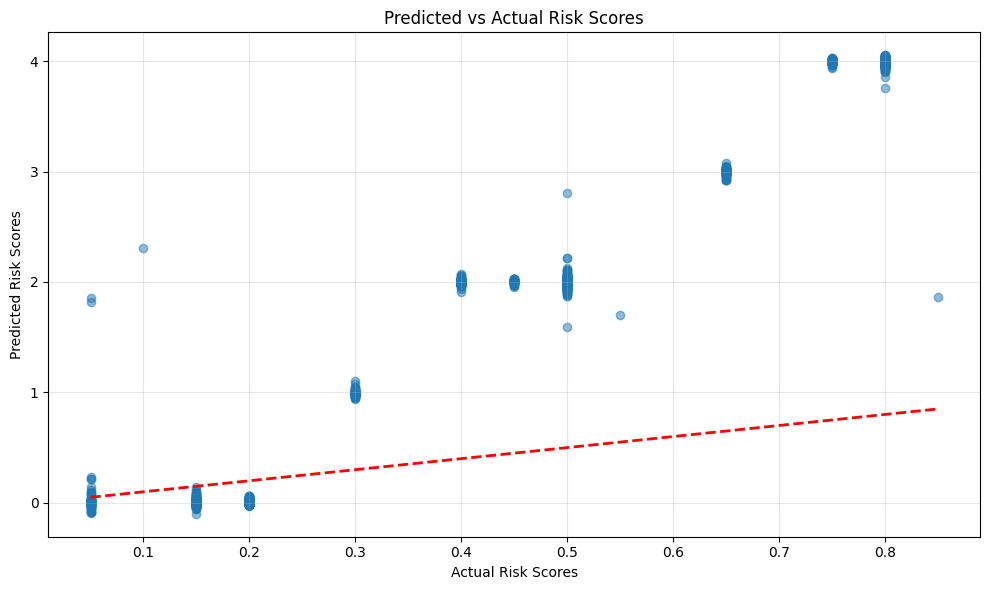

In [13]:
# Get predictions for the entire test set
y_pred = model.predict(X_test)

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Risk Scores')
plt.ylabel('Predicted Risk Scores')
plt.title('Predicted vs Actual Risk Scores')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

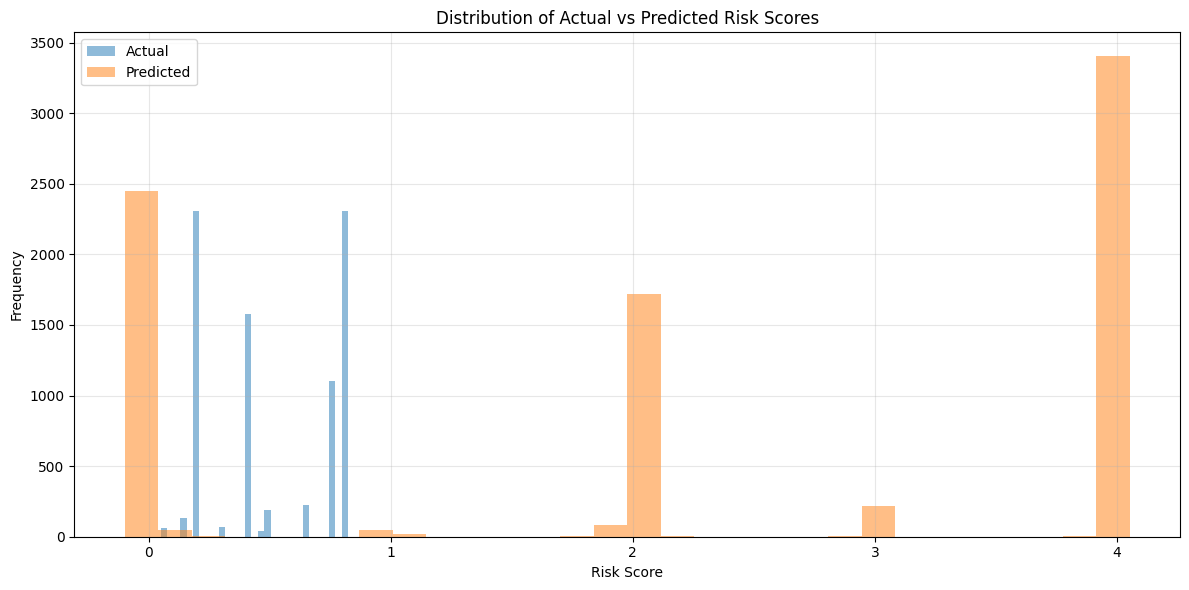

In [14]:
# Distribution of predictions vs actual
plt.figure(figsize=(12, 6))
plt.hist(y_test, bins=30, alpha=0.5, label='Actual')
plt.hist(y_pred, bins=30, alpha=0.5, label='Predicted')
plt.xlabel('Risk Score')
plt.ylabel('Frequency')
plt.title('Distribution of Actual vs Predicted Risk Scores')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()